# 0.0 IMPORTS


In [243]:
import math
import pickle
import inflection

import numpy                                  as np
import pandas                                 as pd
import seaborn                                as sns
import xgboost                                as xgb
import matplotlib.pyplot                      as plt


from scipy                 import stats       as ss
from tabulate              import tabulate
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy

## 0.1. Helper Functions

In [310]:
def cols_rename(df):
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new

def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/(min(k-1, r-1)))
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 8]
    plt.rcParams['font.size'] = 25
    plt.rcParams['figure.autolayout'] = True
    
    display(HTML('<style>.container {width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name':model_name, 
                         'MAE': mae, 
                         'MAPE':mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'KFold Number: {k}')
            
        # start - end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
                         'MAE Cross-Val':np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE Cross-Val':np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE Cross-Val':np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)},index=[0])

In [349]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [80]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

## 1.1 Renaming Columns

In [82]:
df1 = df_raw.copy()

In [83]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

In [84]:
cols_rename(df1)

## 1.2 Data Dimensions

In [85]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [86]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.3 Check NA

In [87]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [88]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Changing Data Type

In [89]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [90]:
num_attr = df1.select_dtypes(include=['int64', 'float64'])
cat_attr = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [91]:
# Central Tendencies
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T
d2 = pd.DataFrame(num_attr.apply(min)).T
d3 = pd.DataFrame(num_attr.apply(max)).T
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [333]:
# Configuring the charts
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)

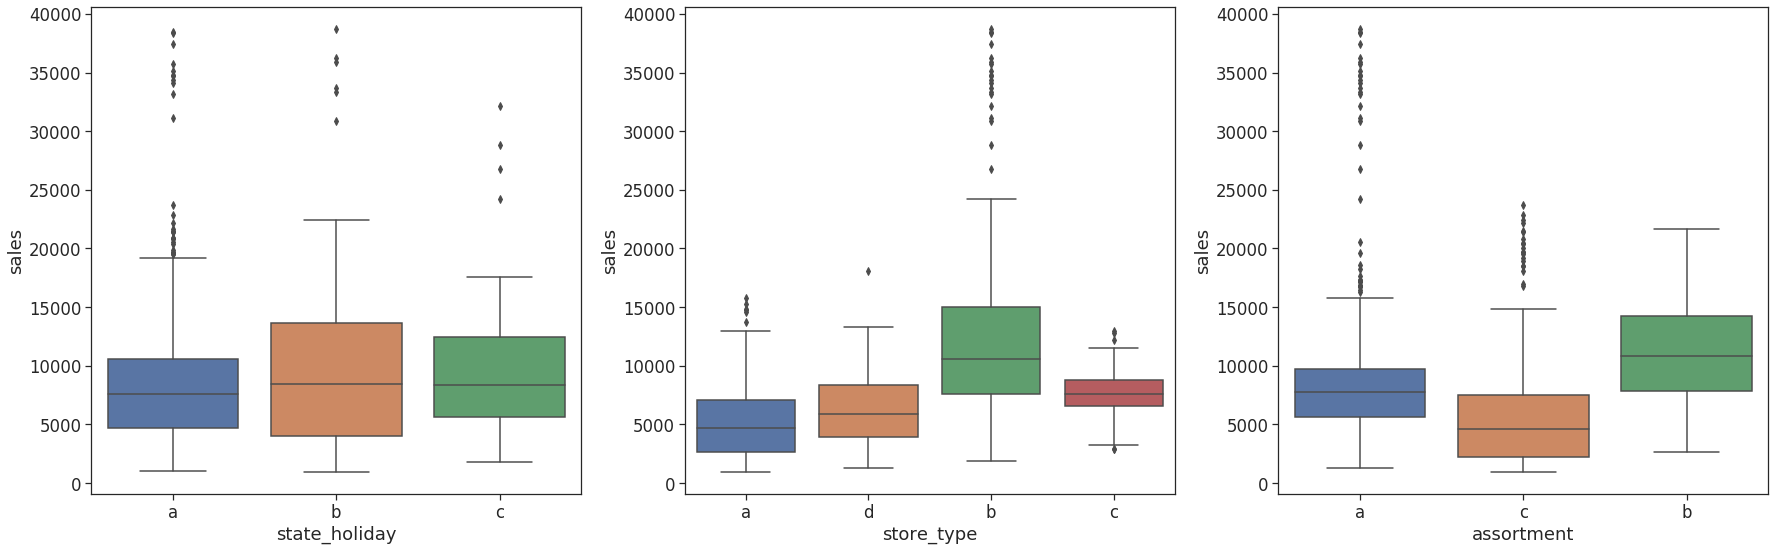

In [334]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# 2.0 FEATURE ENGINEERING

In [93]:
df2 = df1.copy()

## 2.1 MIND MAP HYPOTHESIS

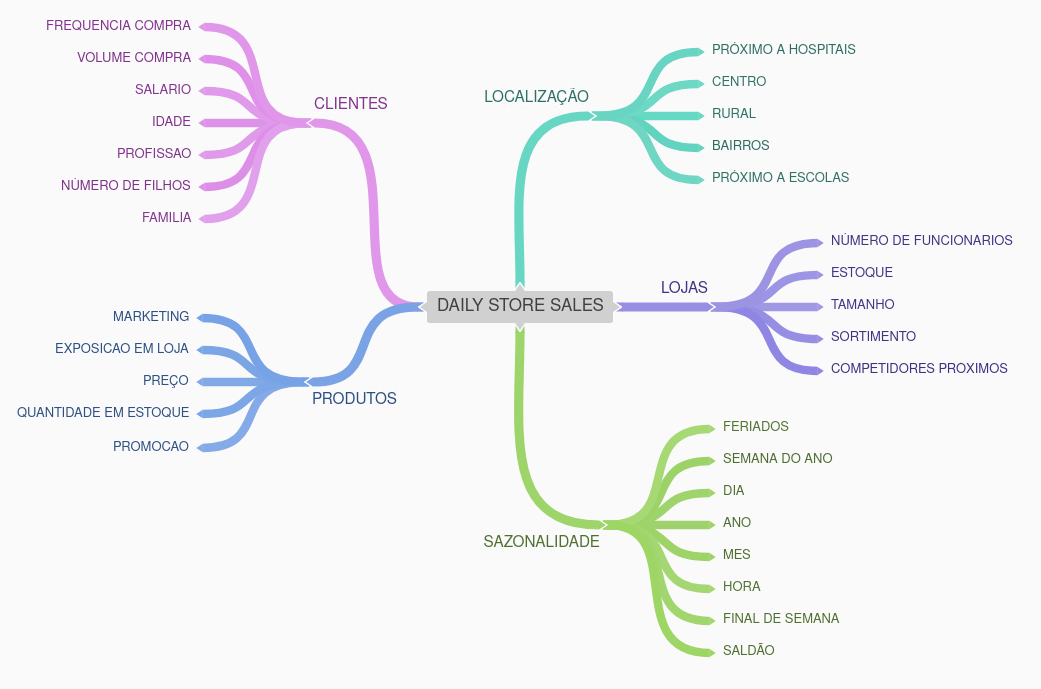

In [94]:
Image('img/mind_map_hypothesis.png')

## 2.2 Creating Hypothesis

### 2.1.1 Store Hypothesis


**1.** Lojas com maior número de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vender menos 

### 2.1.2 Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas com maior exposição de produto deveriam vender mais

**3.** Lojas com produtos com preços menores deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Final Hypothesis

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.4 Feature Engineering

In [95]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'eastern_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

# 3.0 VARIABLE FILTERING

In [96]:
df3 = df2.copy()

## 3.1 Row Filtering

In [97]:
df3 = df3[(df3['open']!= 0)&(df3['sales'] > 0)]

## 3.1 Column Selection

In [98]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [99]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

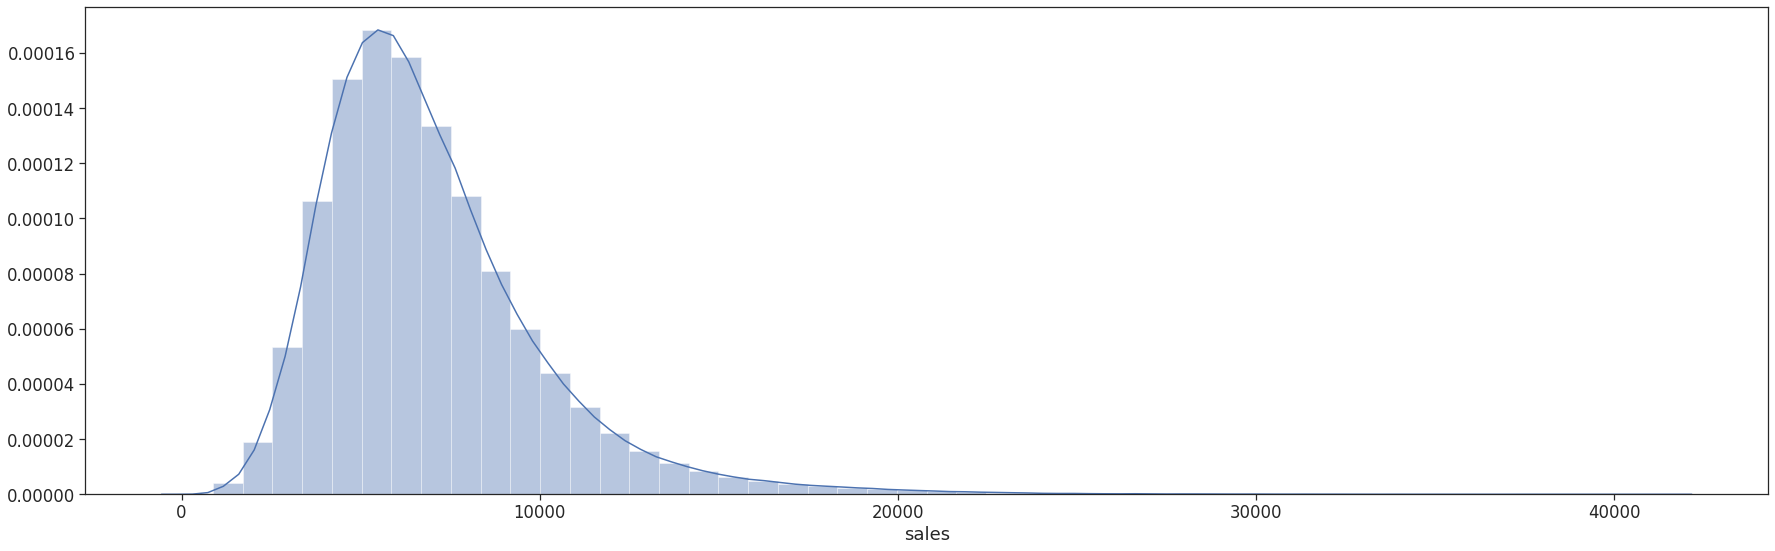

In [335]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variables

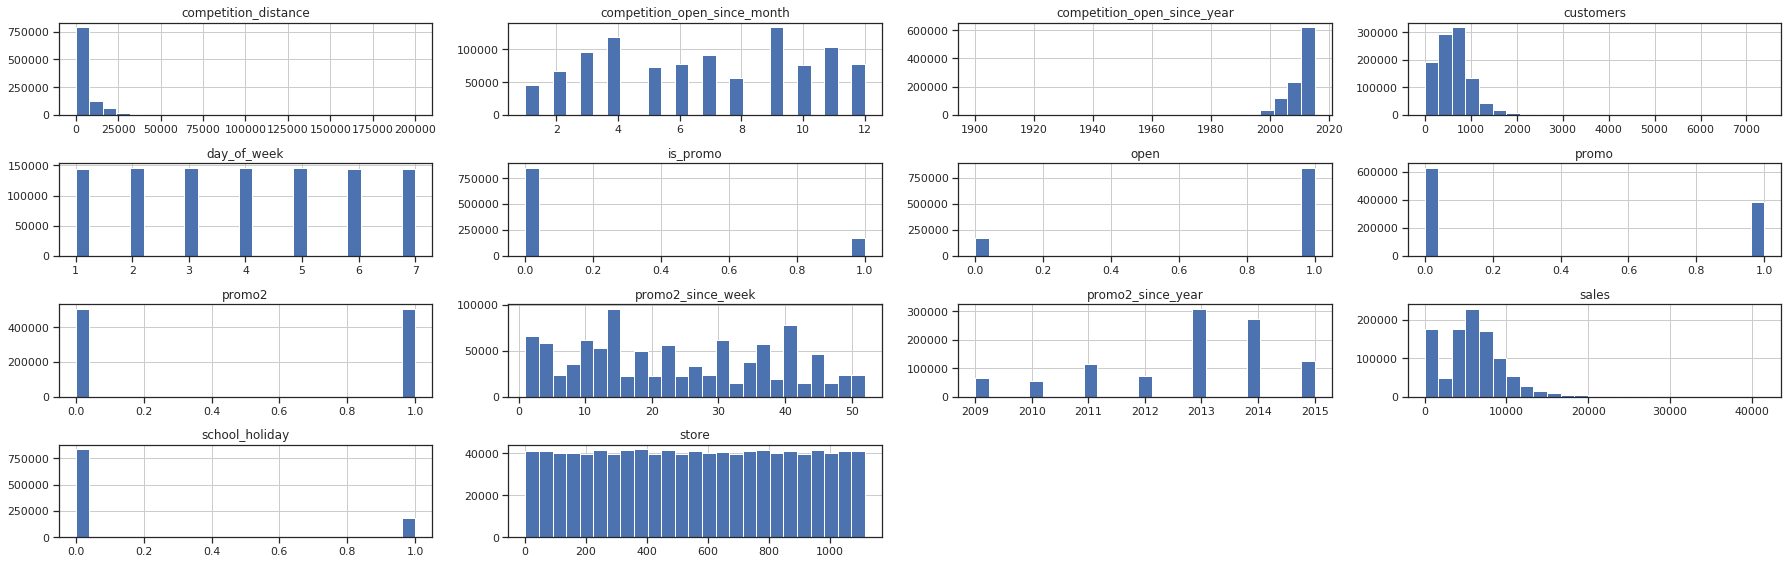

In [345]:
sns.set_style('ticks')
num_attr.hist(bins=25);

### 4.1.3 Categorical Variables

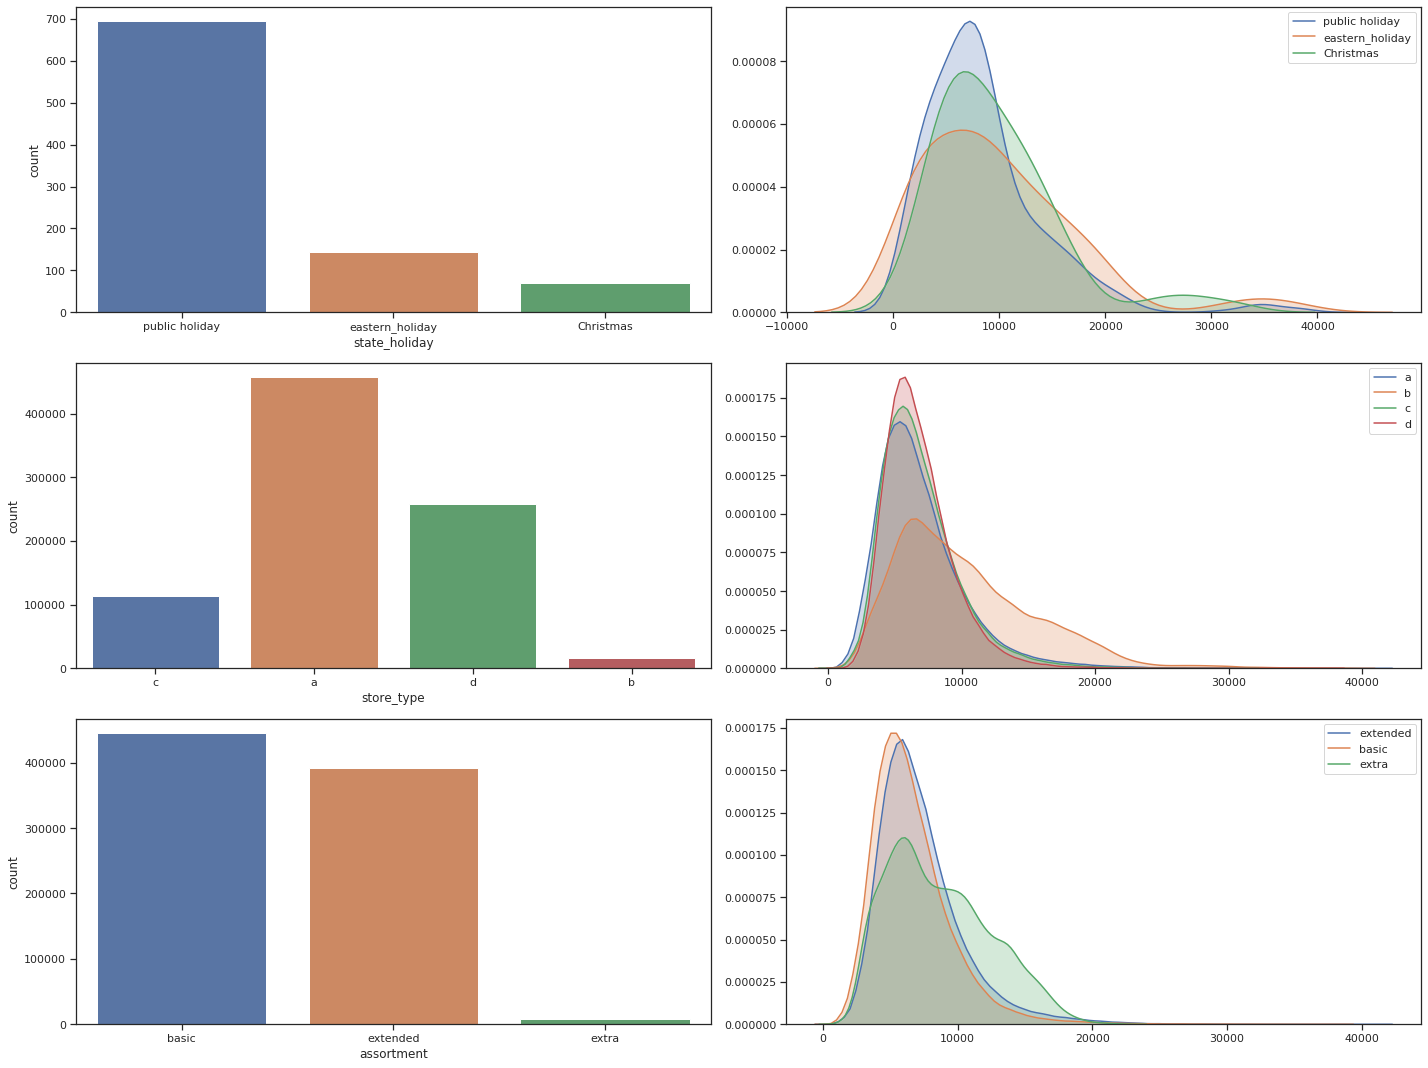

In [354]:
sns.set_style('ticks')

plt.figure(figsize=(20,15))

# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'eastern_holiday']['sales'], label='eastern_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas',shade=True);


# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',shade=True);

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True);

## 4.2 Bivariate Analysis

### **1.** Lojas com maior sortimento deveriam vender mais

**FALSA**: Lojas com maior sortimento vendem MENOS.

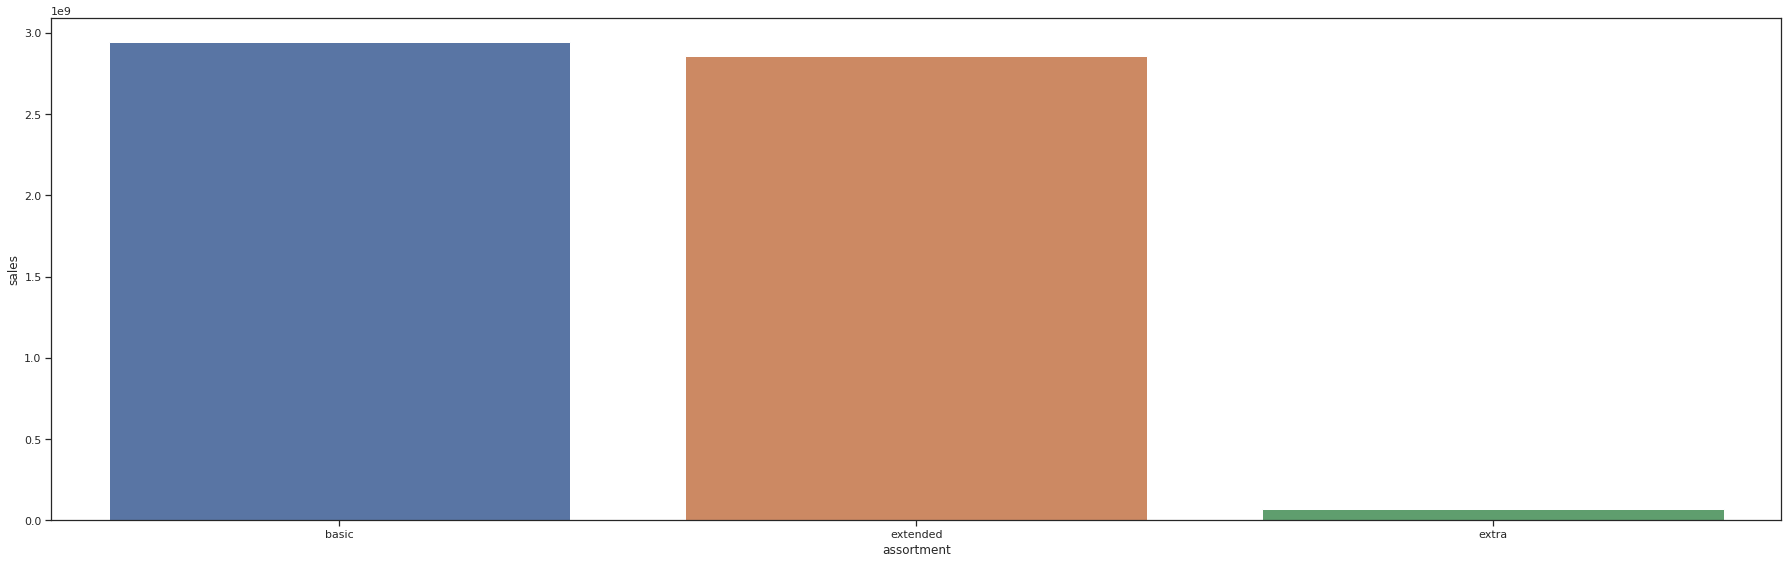

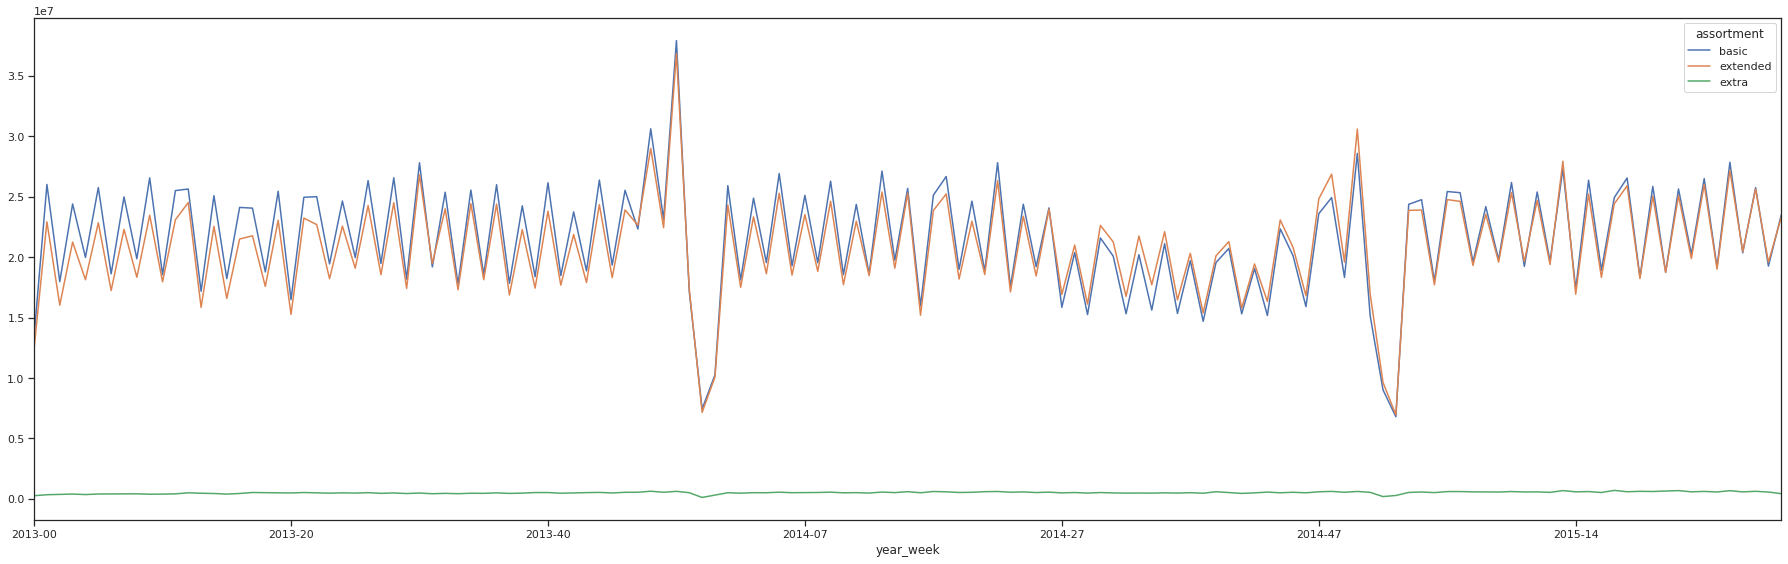

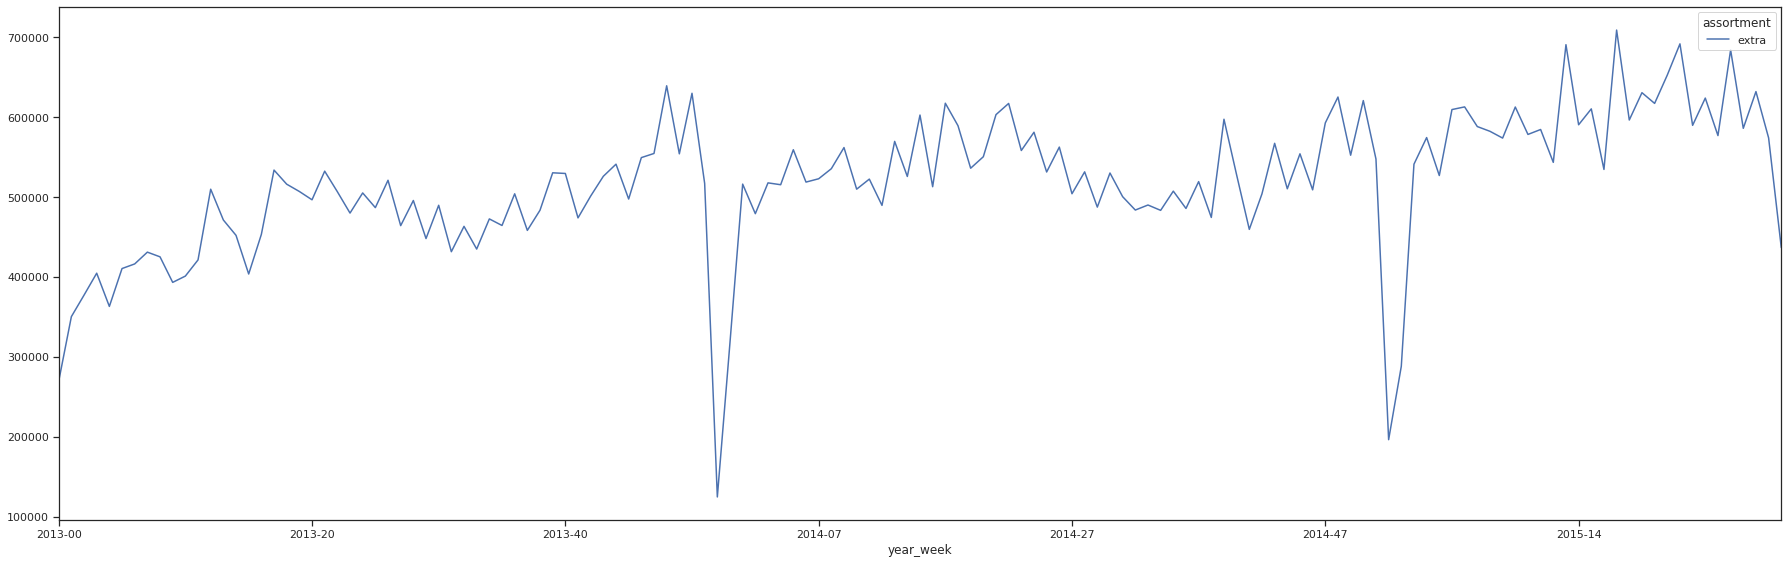

In [355]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **2.** Lojas com competidores mais próximos deveriam vender menos
**FALSA**: Lojas com competidores mais próximos vendem MAIS

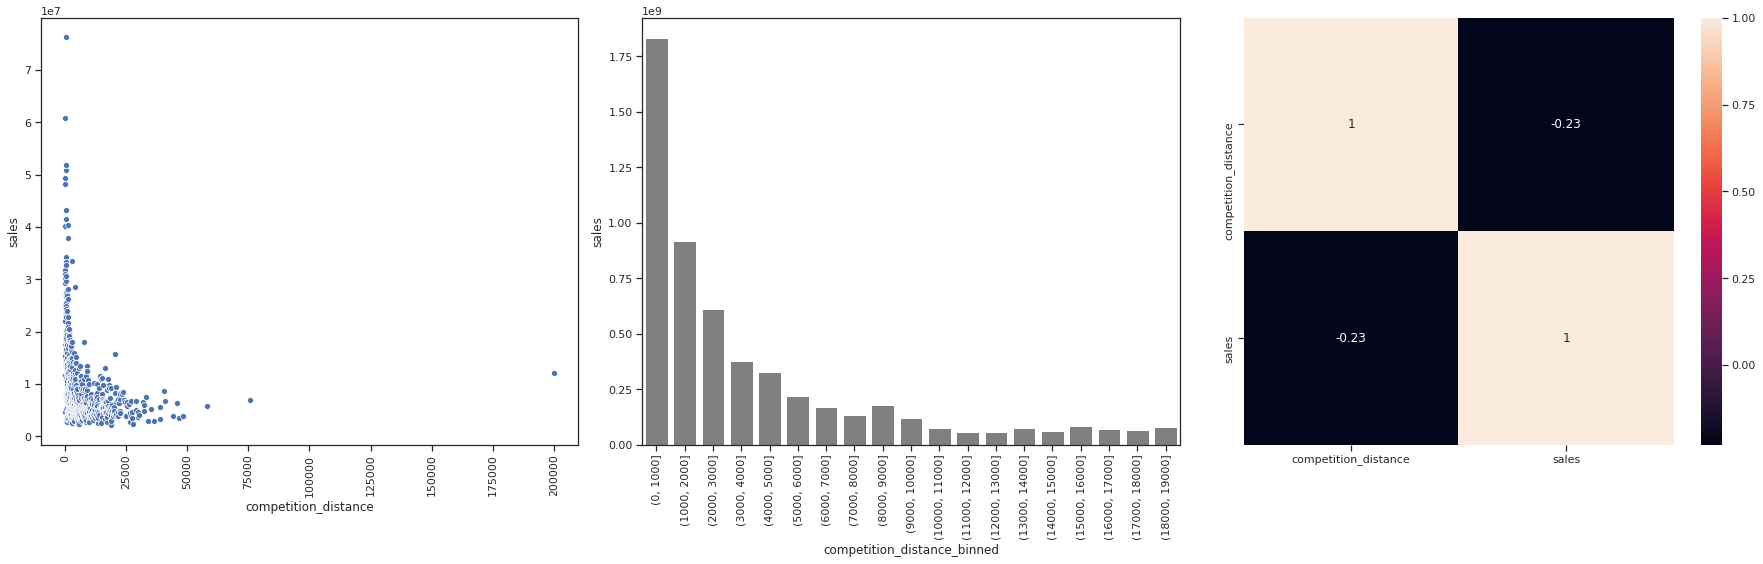

In [357]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, color='grey')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **3.** Lojas com competidores à mais tempo deveriam vender mais

**FALSA**: Lojas com competidores à mais tempo vendem MENOS.

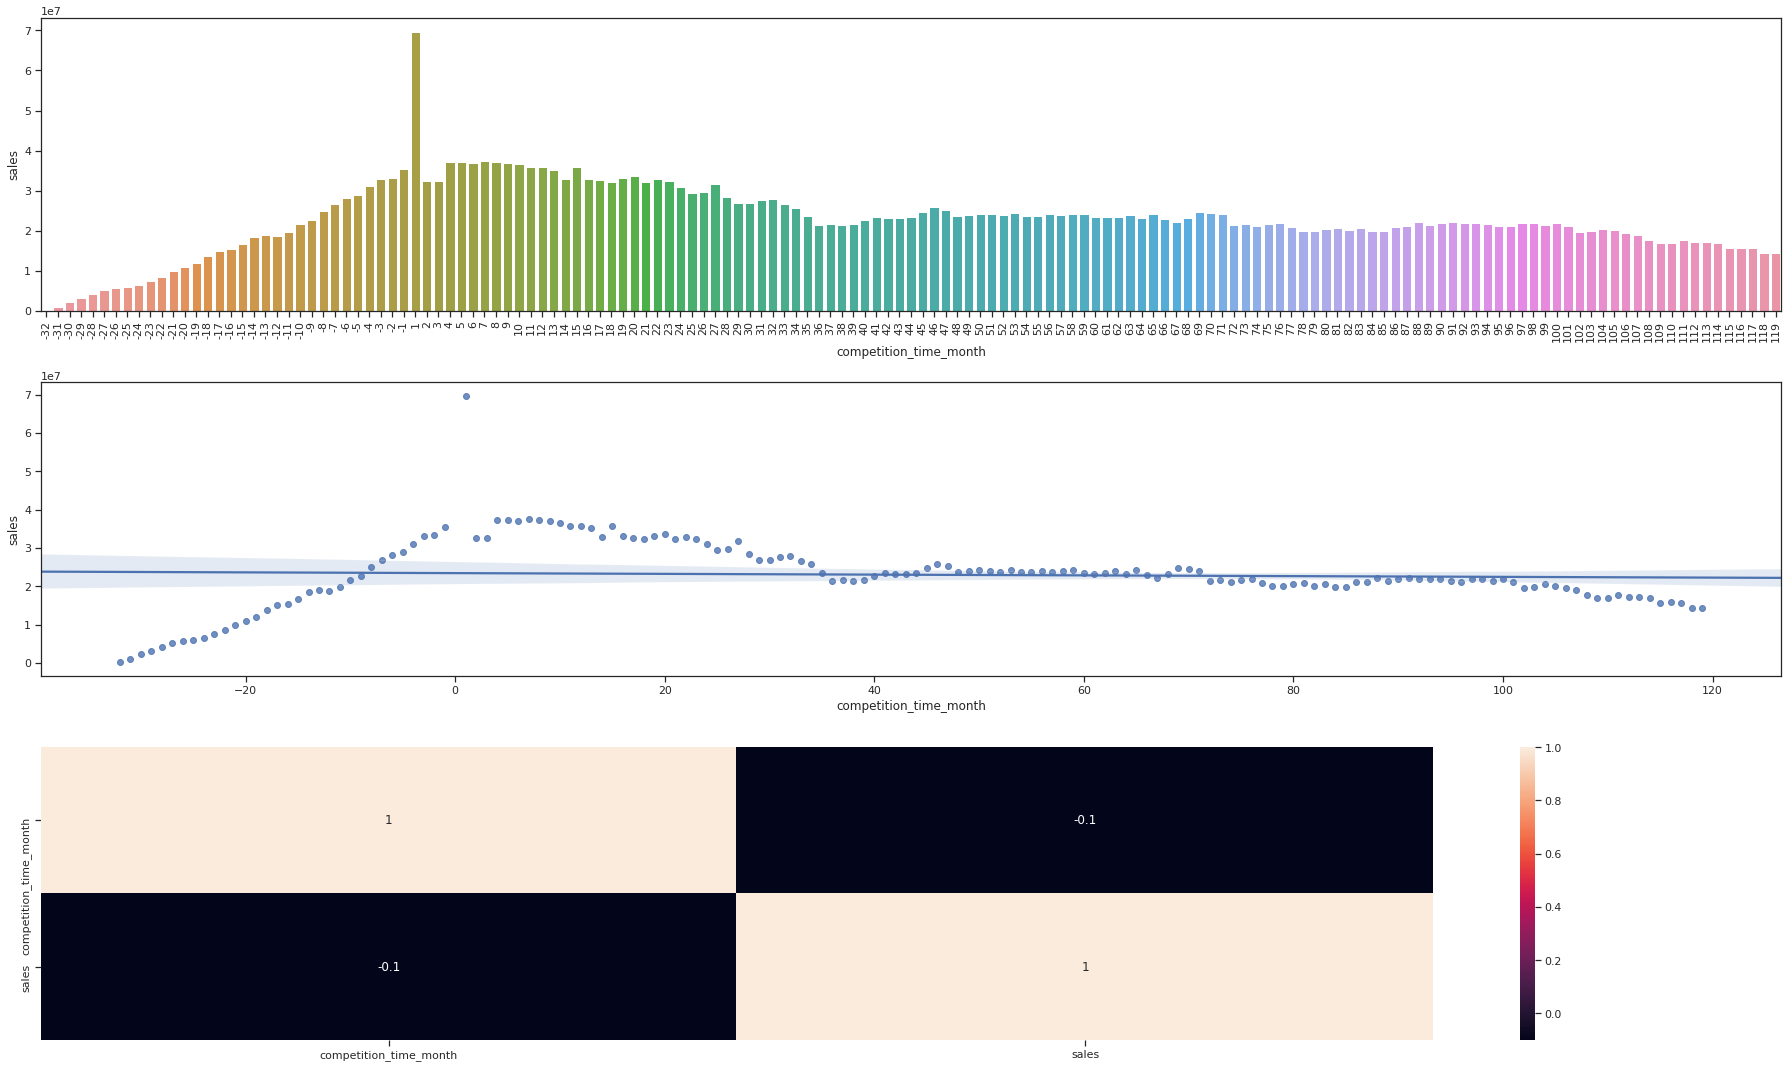

In [389]:
plt.figure(figsize=(25,15))

plt.subplot(3, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(3, 1, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**FALSA**: Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

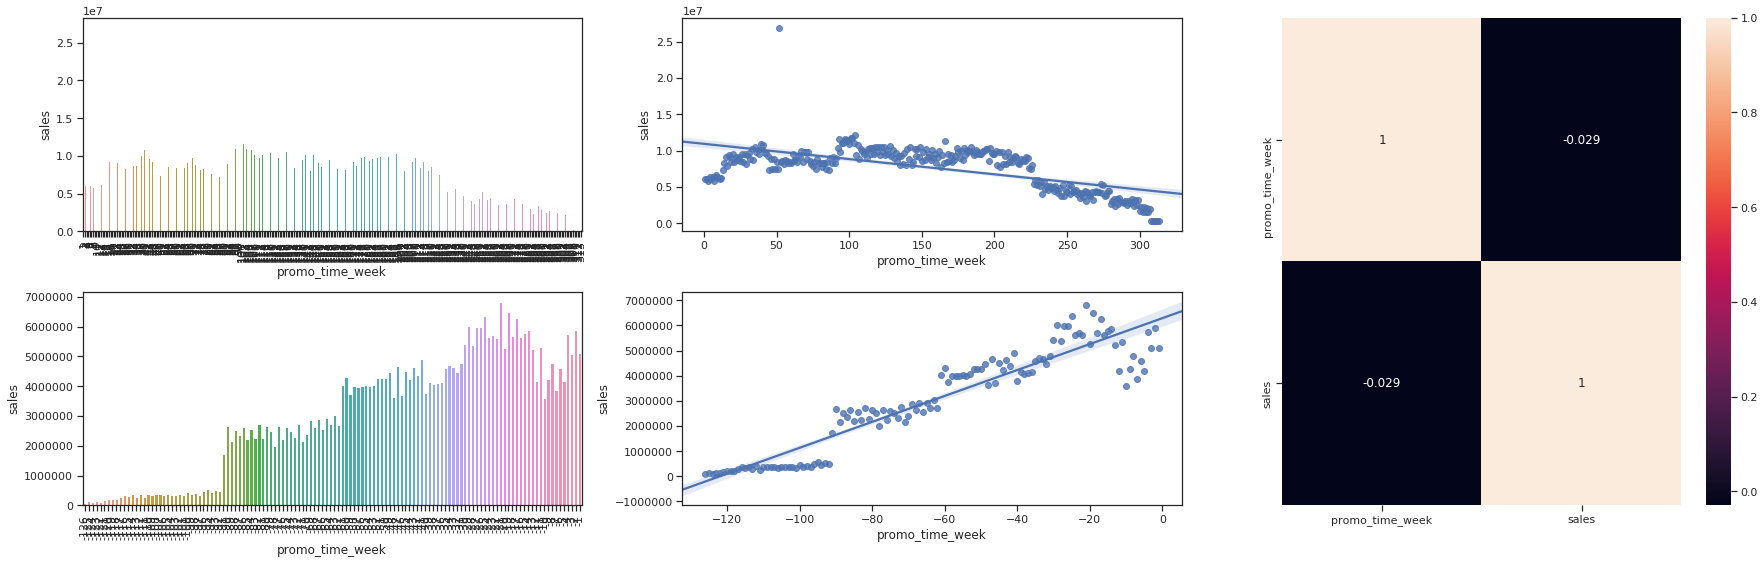

In [370]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### ~**5.** Lojas com mais dias de promoção deveriam vender mais~

### **6.** Lojas com mais promoções consecutivas deveriam vender mais

**FALSA**: Lojas com promoções consecutivas vendem MENOS.

In [108]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


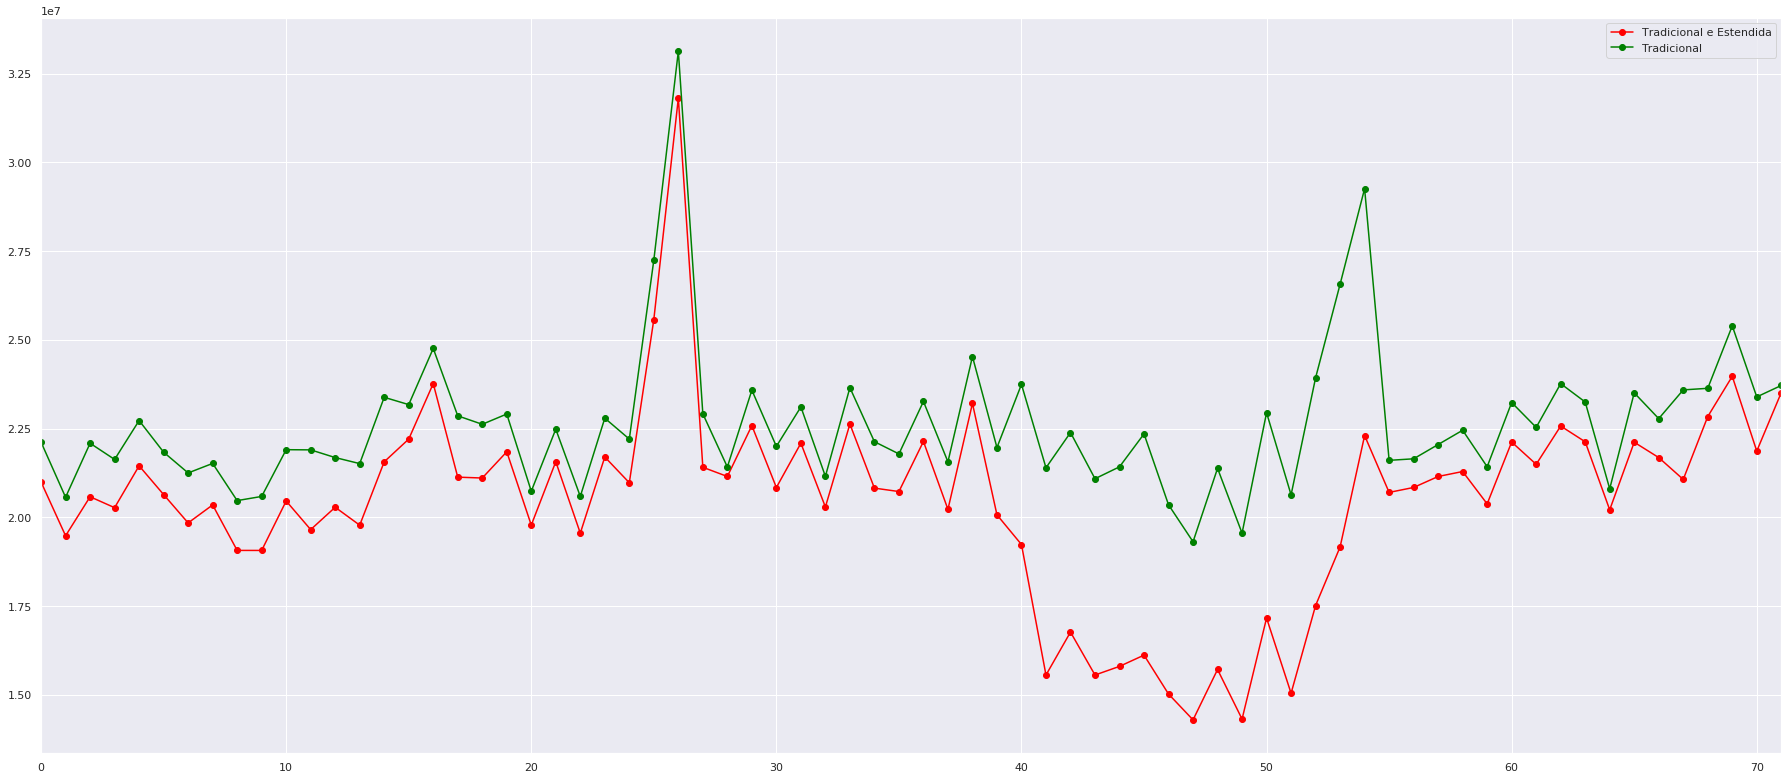

In [218]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(marker='o', figsize=(25,11), color='red')

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax, marker='o', color='green')

ax.legend(labels=['Tradicional e Estendida', 'Tradicional']);

### **7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**FALSA**: Lojas abertas durante o feriado de Natal vendem MENOS.

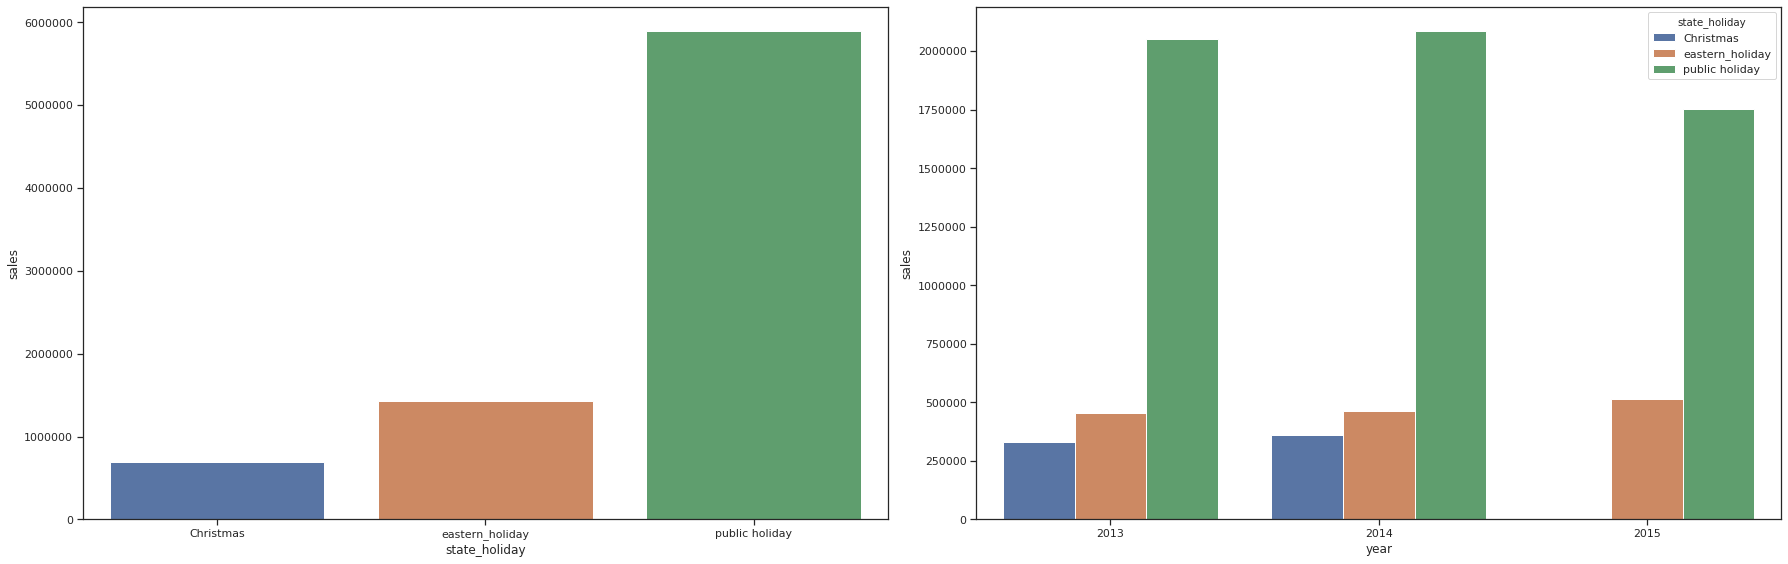

In [390]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **8.** Lojas deveriam vender mais ao longo dos anos

**FALSA**: Lojas vendem MENOS ao longo dos anos.

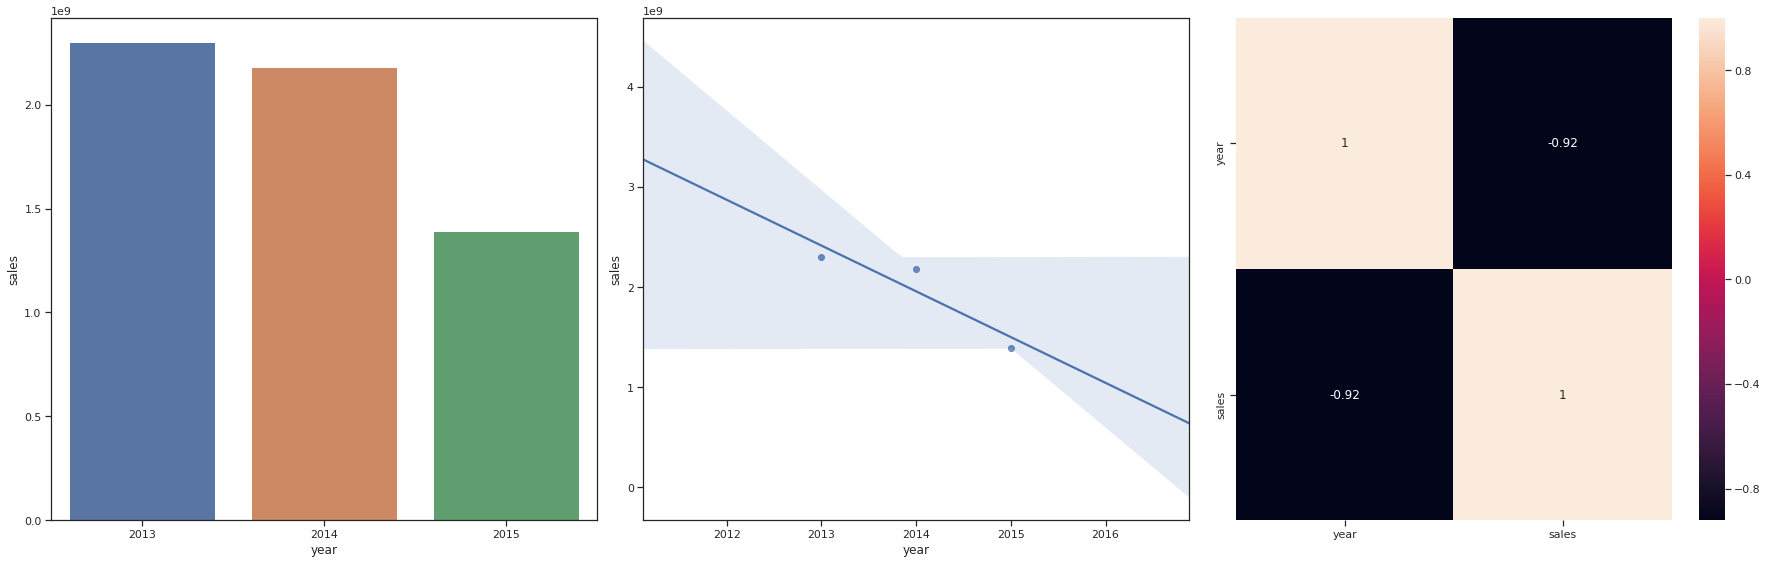

In [391]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **9.** Lojas deveriam vender mais no segundo semestre do ano

**FALSA**: Lojas vendem MENOS no segundo semestre do ano.

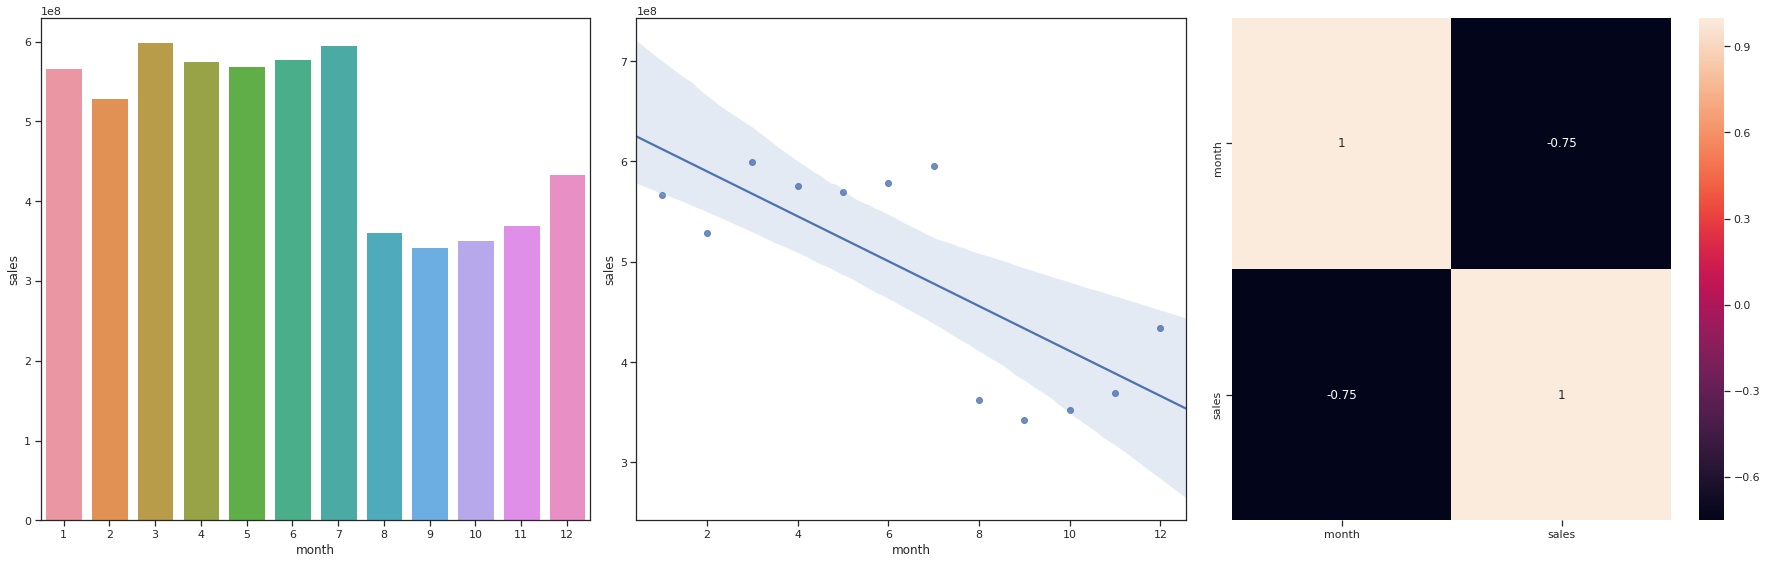

In [392]:
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**VERDADEIRA**: Lojas vendem MAIS depois do dia 10 de cada mês.

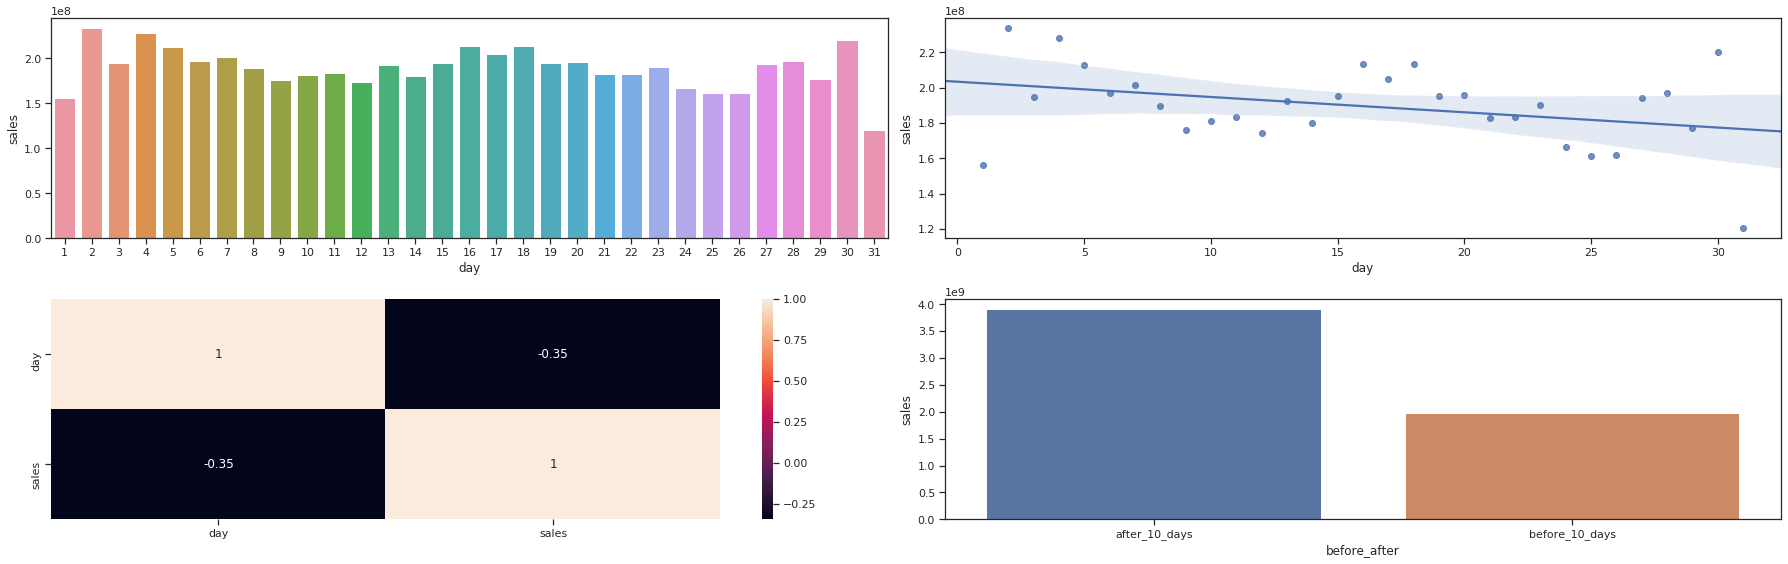

In [393]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **11.** Lojas deveriam vender menos aos finais de semana
**VERDADEIRA**: Lojas vendem MENOS aos finais de semana.

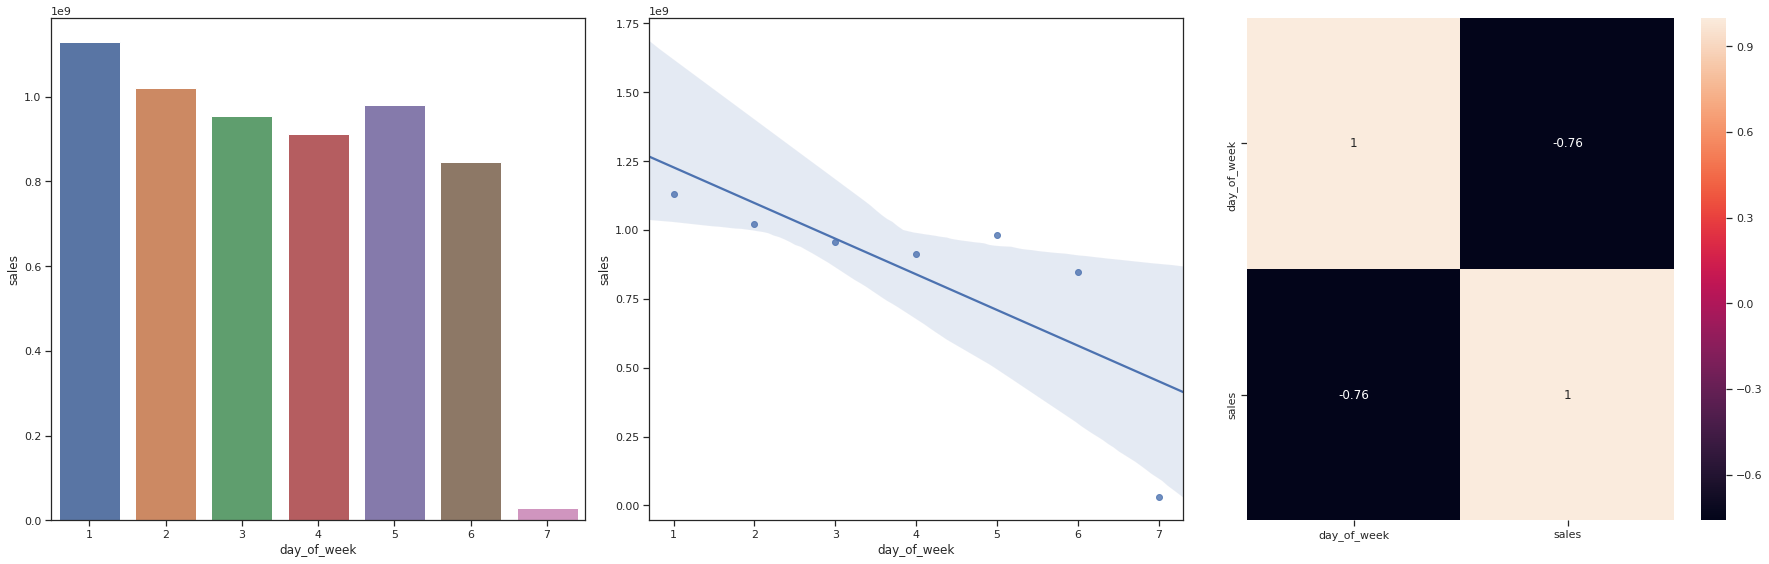

In [396]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares

**VERDADEIRA**: Lojas vendem MENOS durante os feriados escolares, exceto os meses de Julho e Agosto.

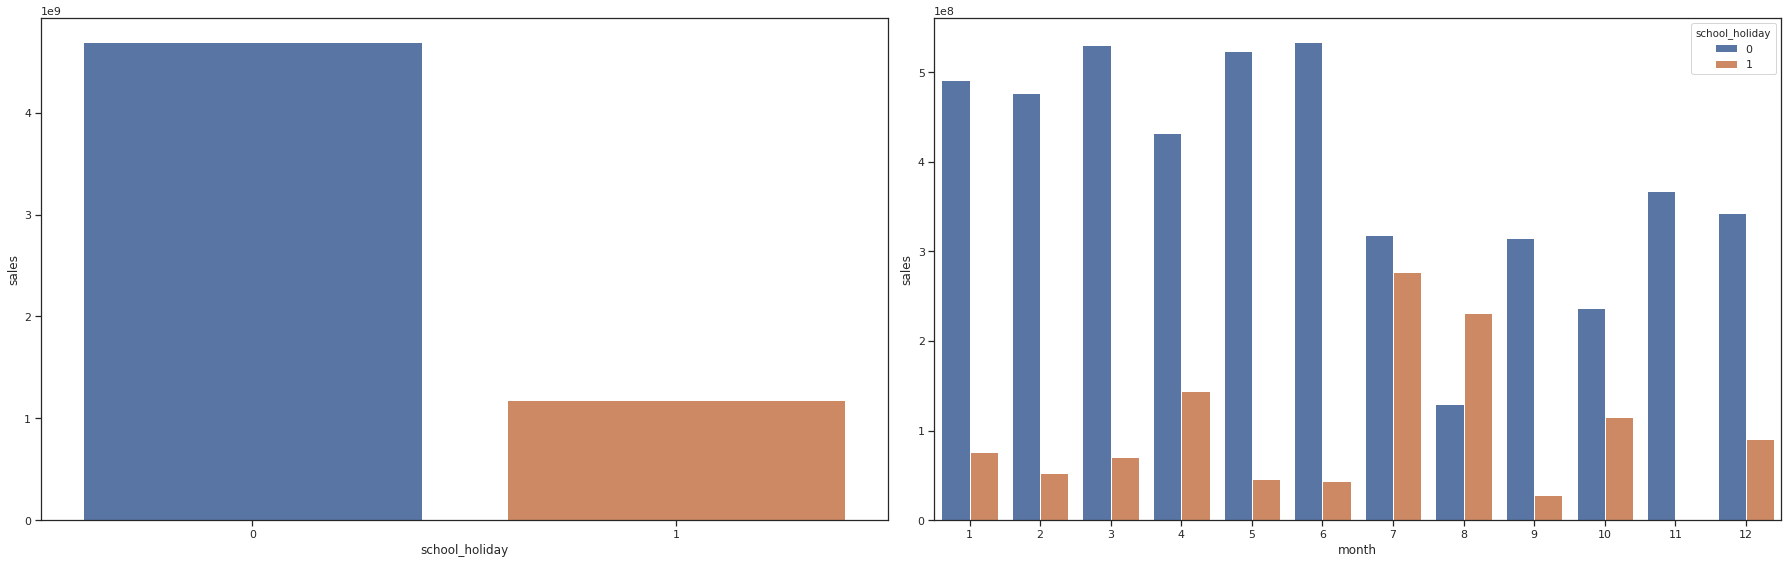

In [398]:
plt.subplot(1, 2, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Hypothesis

In [116]:
tab = [['Hypothesis', 'Conclusion', 'Relevance?'],
       ['H1', 'FALSE', 'Low'],
       ['H2', 'FALSE', 'Medium'],
       ['H3', 'FALSE', 'Medium'],
       ['H4', 'FALSE', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'FALSE', 'Low'],
       ['H7', 'FALSE', 'Medium'],
       ['H8', 'FALSE', 'High'],
       ['H9', 'FALSE', 'High'],
       ['H10', 'TRUE', 'High'],
       ['H11', 'TRUE', 'High'],
       ['H12', 'TRUE', 'Low'],]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance?
------------  ------------  ------------
H1            FALSE         Low
H2            FALSE         Medium
H3            FALSE         Medium
H4            FALSE         Low
H5            -             -
H6            FALSE         Low
H7            FALSE         Medium
H8            FALSE         High
H9            FALSE         High
H10           TRUE          High
H11           TRUE          High
H12           TRUE          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

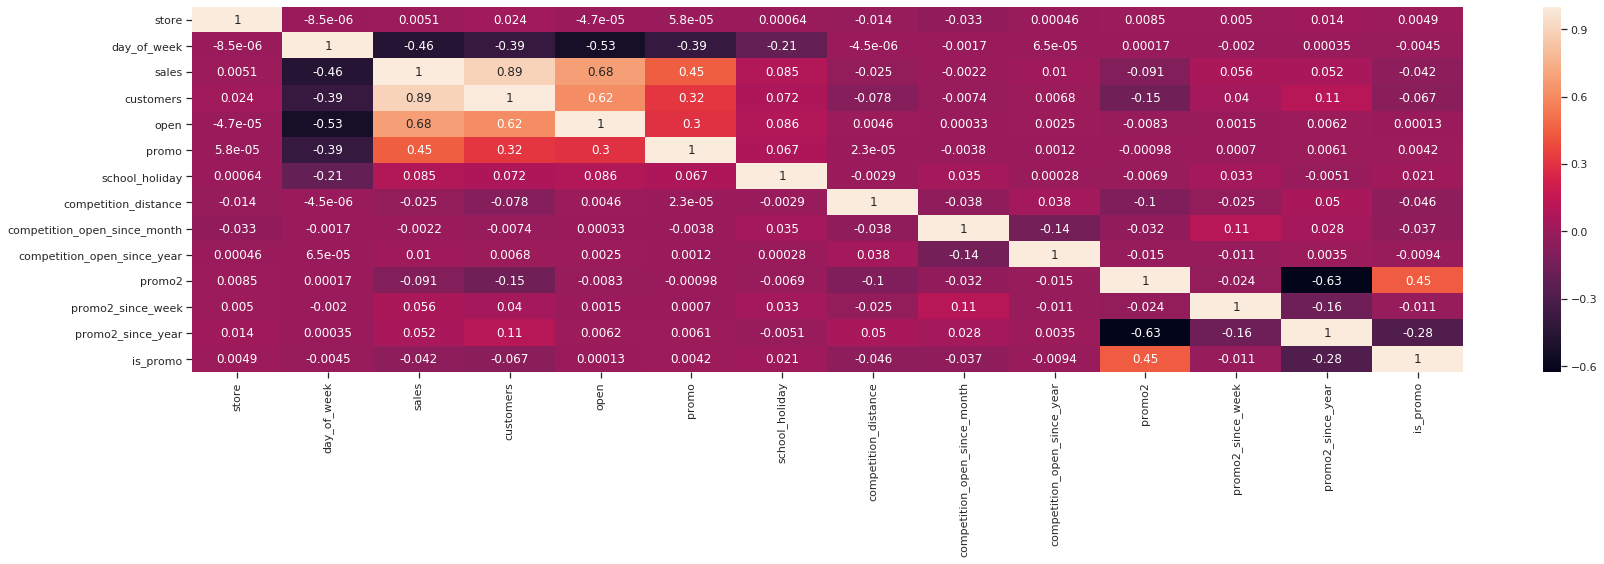

In [399]:
correlation = num_attr.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

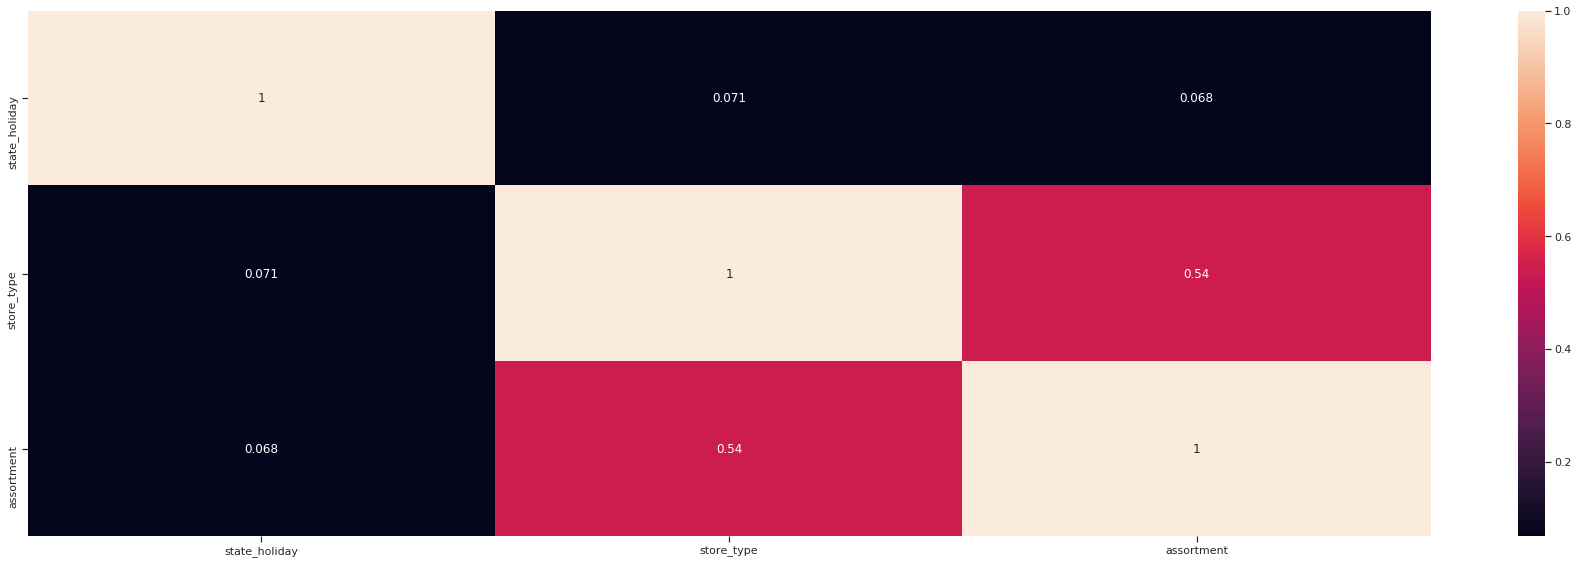

In [400]:
# Filtering only categorical data
a = df4.select_dtypes(include='object')

# Calculating the Cramer's V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [119]:
df5 = df4.copy()

## 5.1 Rescaling

In [120]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.2 Transformation

### 5.2.1 Encoding

In [121]:
# state_holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

## 5.2.2 Response Variable Transformation

In [122]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [123]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2 * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2 * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2 * np.pi/52)))

# 6.0 FEATURE SELECTION

In [124]:
df6 = df5.copy()

## 6.1 Split dataframe into training and dataset

In [125]:
cols_drop = ['week_of_year',
             'day',
             'month',
             'day_of_week',
             'promo_since',
             'competition_since',
             'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [126]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as Feature Selector

In [128]:
# Training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [129]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date','sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [130]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2', 
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos'
]

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# final features
# cols_selected_boruta.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELLING

In [131]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [132]:
# model
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [133]:
# model 
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [134]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE Cross-Val,MAPE Cross-Val,RMSE Cross-Val
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model (Lasso)

In [135]:
# model 
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized (Lasso) - Cross Validation

In [136]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE Cross-Val,MAPE Cross-Val,RMSE Cross-Val
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Model

In [137]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.24895


### 7.4.1 Random Forest Regressor - Cross Validation

In [138]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor ', rf, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE Cross-Val,MAPE Cross-Val,RMSE Cross-Val
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


## 7.5 XGBoost Model

In [139]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112292,0.122609,1250.952634


### 7.5.1 XGBoost Regressor - Cross Validation

In [141]:
model_xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor ', model_xgb, verbose=True)
model_xgb_result_cv

KFold Number: 5
KFold Number: 4


/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold Number: 3


/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold Number: 2


/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


KFold Number: 1


/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/brian/.pyenv/versions/3.8.0/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE Cross-Val,MAPE Cross-Val,RMSE Cross-Val
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6 Comparing Model's Performance

### 7.6.1 Normal

In [142]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.248950
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [401]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.296634,0.099816,1008.248950
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.1 Cross-Validation

In [143]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, model_xgb_result_cv])
modelling_result_cv

,Model Name,MAE Cross-Val,MAPE Cross-Val,RMSE Cross-Val
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [144]:
import random
import warnings
warnings.filterwarnings('ignore')

In [145]:
# param = {
#     'n_estimators':[1500, 1700, 2500, 3000, 3500],
#     'eta':[0.01, 0.03],
#     'max_depth':[3, 5, 9],
#     'subsample':[0.1, 0.5, 0.7],
#     'colsample_bytee':[0.3, 0.7, 0.9],
#     'min_child_weight':[3, 8, 15]
# }

# MAX_EVAL = 2

In [146]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choosing values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
    
#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],/
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytee'],
#                                  min_child_weight=hp['min_child_weight'])

#     # performance
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

## 8.1 Final Model

In [157]:
param_tuned = {
    'n_estimators':3000,
    'eta':0.03,
    'max_depth':5,
    'subsample':0.7,
    'colsample_bytee':0.7,
    'min_child_weight':3
}

In [240]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'], 
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytee'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

In [239]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


In [237]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.003545334084016699

# 9.0 INTERPRETING ERRORS

In [238]:
df9 = X_test[cols_selected_boruta_full.copy()]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [161]:
# Sum of Predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordering Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [241]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.078125,100714.973723,107351.182527,3318.104402,0.565828
908,909,238233.875000,230573.337190,245894.412810,7660.537810,0.520433
875,876,203030.156250,199110.952456,206949.360044,3919.203794,0.305099
721,722,353005.781250,351013.625224,354997.937276,1992.156026,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


In [242]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
600,601,180908.3750,180467.156092,181349.593908,441.218908,0.089756
354,355,331175.1875,330536.694837,331813.680163,638.492663,0.066591
1024,1025,264942.3125,264352.149308,265532.475692,590.163192,0.080962
253,254,119739.2500,119390.768271,120087.731729,348.481729,0.114057


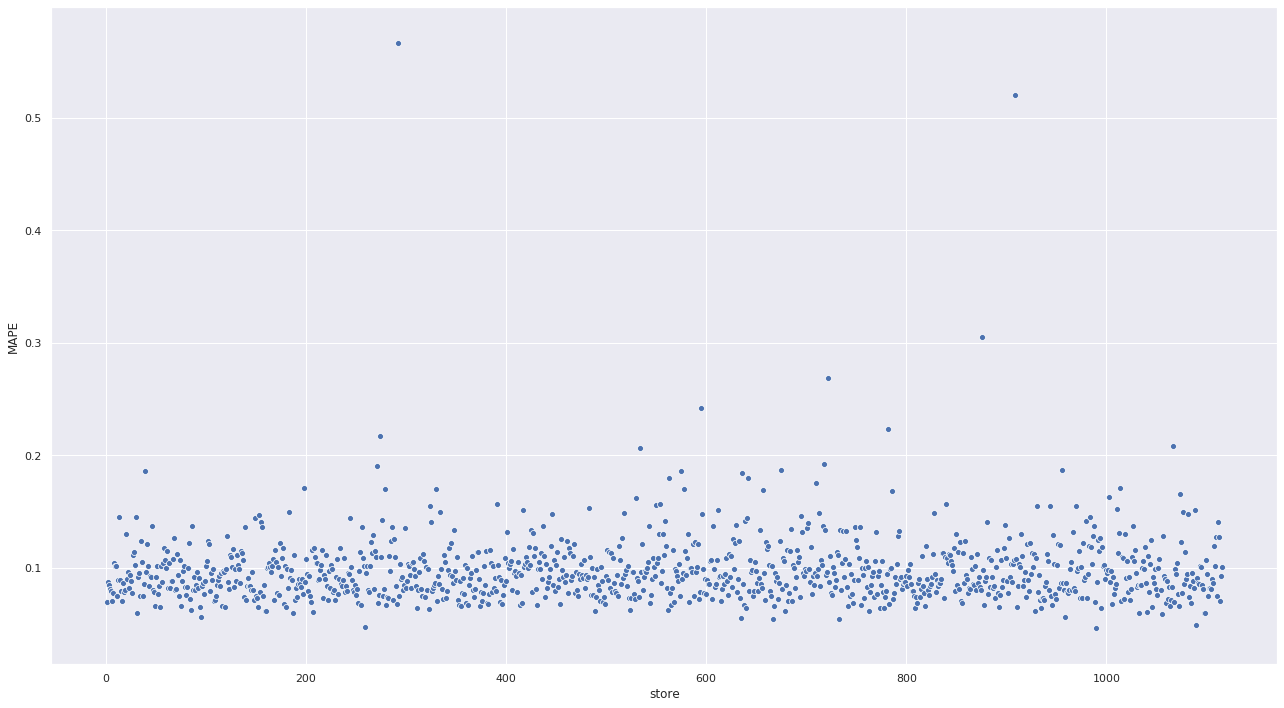

In [164]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [165]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,860,497.74"
1,worst_scenario,"R$285,115,015.68"
2,best_scenario,"R$286,605,979.81"


## 9.3 Machine Learning Performance

In [403]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

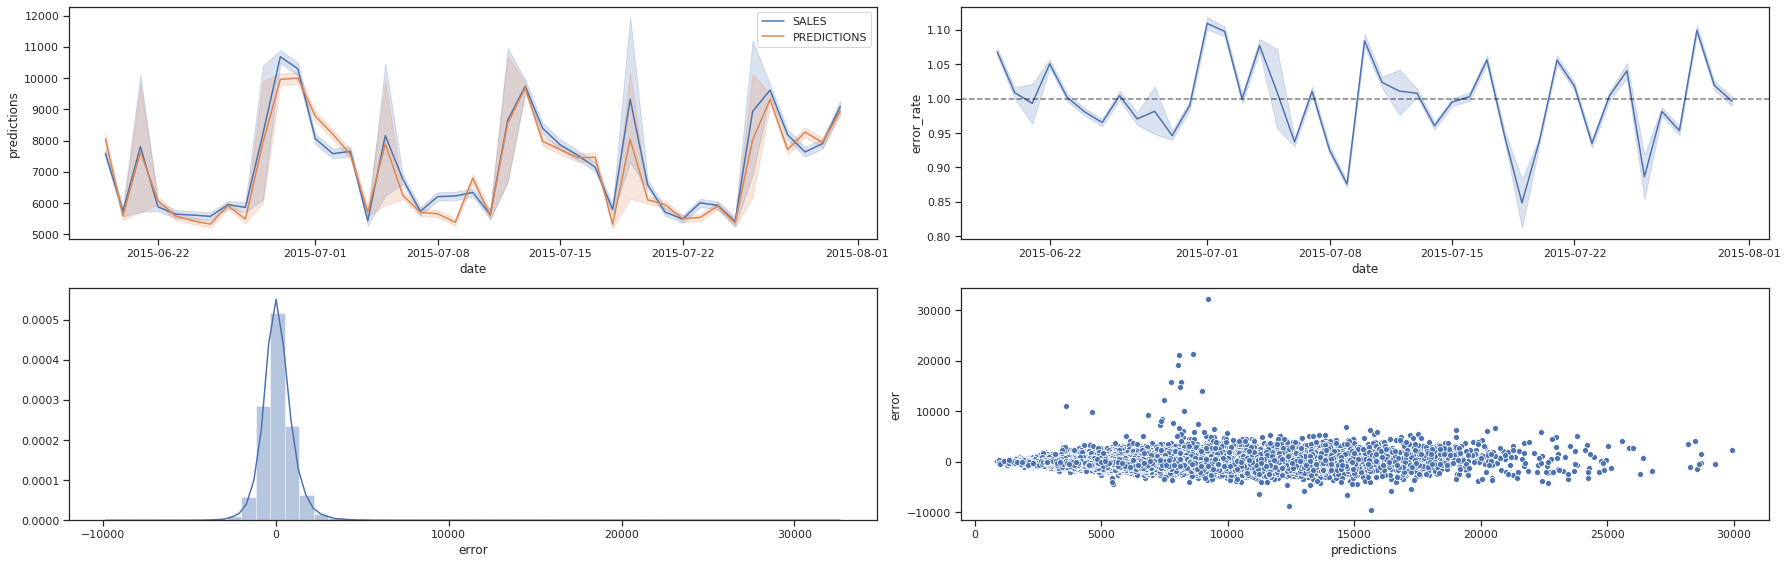

In [404]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--', color='black', alpha=0.5)

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 DEPLOYING MODEL TO PRODUCTION

In [168]:
# Saving Trained Model
pickle.dump(model_xgb_tuned, open('/home/brian/Documents/data_science/portfolio/rossmann-sales-prediction/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [270]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/brian/Documents/data_science/portfolio/rossmann-sales-prediction/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))


        state = 1
        
    def data_cleaning(self, df1):
        
        # Renaming Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
    
        cols_new = list(map(snakecase, cols_old))
    
        df1.columns = cols_new


        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Changing Data Type

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1


    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'eastern_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

        # 3.0 VARIABLE FILTERING
        ## 3.1 Row Filtering

        df2 = df2[(df2['open']!= 0)]

        ## 3.1 Column Selection

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2


    def data_preparation(self, df5):

        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        
        ### 5.3.1 Encoding
        # state_holiday - One Hot Enconding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        

        ### 5.3.3 Nature Transformation

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2 * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2 * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2 * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2 * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2',  
                        'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                         'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # Join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [272]:
import pickle
import pandas as pd

from flask                import Flask, request, Response
from rossmann.Rossmann    import Rossmann

# Loading model
model = pickle.load(open('/home/brian/Documents/data_science/portfolio/rossmann-sales-prediction/model/model_rossmann.pkl', 'rb'))

# Initializing API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # There is data
        if isinstance(test_json, dict):        # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # Multiple Examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [289]:
import requests

In [290]:
# Loading Dataset
df10 = pd.read_csv('/home/brian/Documents/data_science/portfolio/rossmann-sales-prediction/data/test.csv')

In [302]:
# Merging Test Dataser + Store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([1,12,22])]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [303]:
# Converting Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [304]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-service.onrender.com/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [305]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [306]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()


for i in range(len(d2)):
    print('Store Number: {} will sell {:,.2f} in the next 6 weeks.'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number: 1 will sell 204,308.20 in the next 6 weeks.
Store Number: 12 will sell 262,750.34 in the next 6 weeks.
Store Number: 22 will sell 132,046.68 in the next 6 weeks.


In [ ]:
import json
import requests
import pandas as pd

from flask import Flask, request, response

# constants
TOKEN = '8587959221:AAFjcqdUwr4InbFhZXmcnlMDLtX0I_7HgNA'

# Info about the bot
https://api.telegram.org/bot8587959221:AAFjcqdUwr4InbFhZXmcnlMDLtX0I_7HgNA/getMe

# Get updates
https://api.telegram.org/bot8587959221:AAFjcqdUwr4InbFhZXmcnlMDLtX0I_7HgNA/getUpdates

# Send message
https://api.telegram.org/bot8587959221:AAFjcqdUwr4InbFhZXmcnlMDLtX0I_7HgNA/sendMessage?chat_id=7542889863&text=Hi


def send_message(chat_id, text):
    url = f'https://api.telegram.org/bot{TOKEN}'
    url = url + f'sendMessage?chat_id={chat_id}'
    
    r = request.post(url, json={'text':text}
    print(f'Status Code {r_status_code}')

    return None

def load_dataset(store_id):

    # Loading Dataset
    df10 = pd.read_csv('/home/brian/Documents/data_science/portfolio/rossmann-sales-prediction/data/test.csv')
    df_store_raw = pd.read_csv('/home/brian/Documents/data_science/portfolio/rossmann-sales-prediction/data/store.csv')

    # Merging Test Dataser + Store
    df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

    # Choose store for prediction
    df_test = df_test[df_test['Store'] == store_id]
          
    if not df_test.empty:
          # Remove closed days
          df_test = df_test[df_test['Open'] != 0]
          df_test = df_test[~df_test['Open'].isnull()]
          df_test = df_test.drop('Id', axis=1)
          
          # Converting Dataframe to json
          data = json.dumps(df_test.to_dict(orient='records'))
    else:
          data = 'error'
          
    return data

def predict(data):

    # API Call
    # url = 'http://0.0.0.0:5000/rossmann/predict'
    url = 'https://rossmann-service.onrender.com/rossmann/predict'
    header = {'Content-type':'application/json'}
    data = data

    r = requests.post(url, data=data, headers=header)
    print(f'Status Code {r.status_code}')

    d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
    
    return d1

def parse_message(message):
    chat_id = message['message']['chat']['id']
    store_id = messsage['message']['text']
    
    store_id = store_id.replace('/', '')

    try:
    store_id = int(store_id)
    
    except ValueError:
    store_id = 'error'

    return chat_id, store_id


# API initialize
app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])

def index():
    if request.method == 'POST':
        message = request.get_json()

        chat_id, store_id = parse_message(message)

        if store_id != 'error':
            # loading data
            data = load_dataset(store_id)

            if data != 'error':
                # prediction
                d1 = predict(data)
                # calculation
                d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
                msg = f'Store Number: {} will sell {} in the next 6 weeks.'.format(d2['store'].values[0], d2['prediction'].values[0])

                # send message
                send_message(chat_id, msg)
                return Response('OK', status=200)

            else:
                end_message(chat_id, 'Wrong Store ID')
                return Response('OK', status=200)
        else:
            send_message(chat_id, 'Wrong Store ID')
            return Response('OK', status=200)
    else:
        return '<h1> Rossmann Telegram BOT </h1>

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)